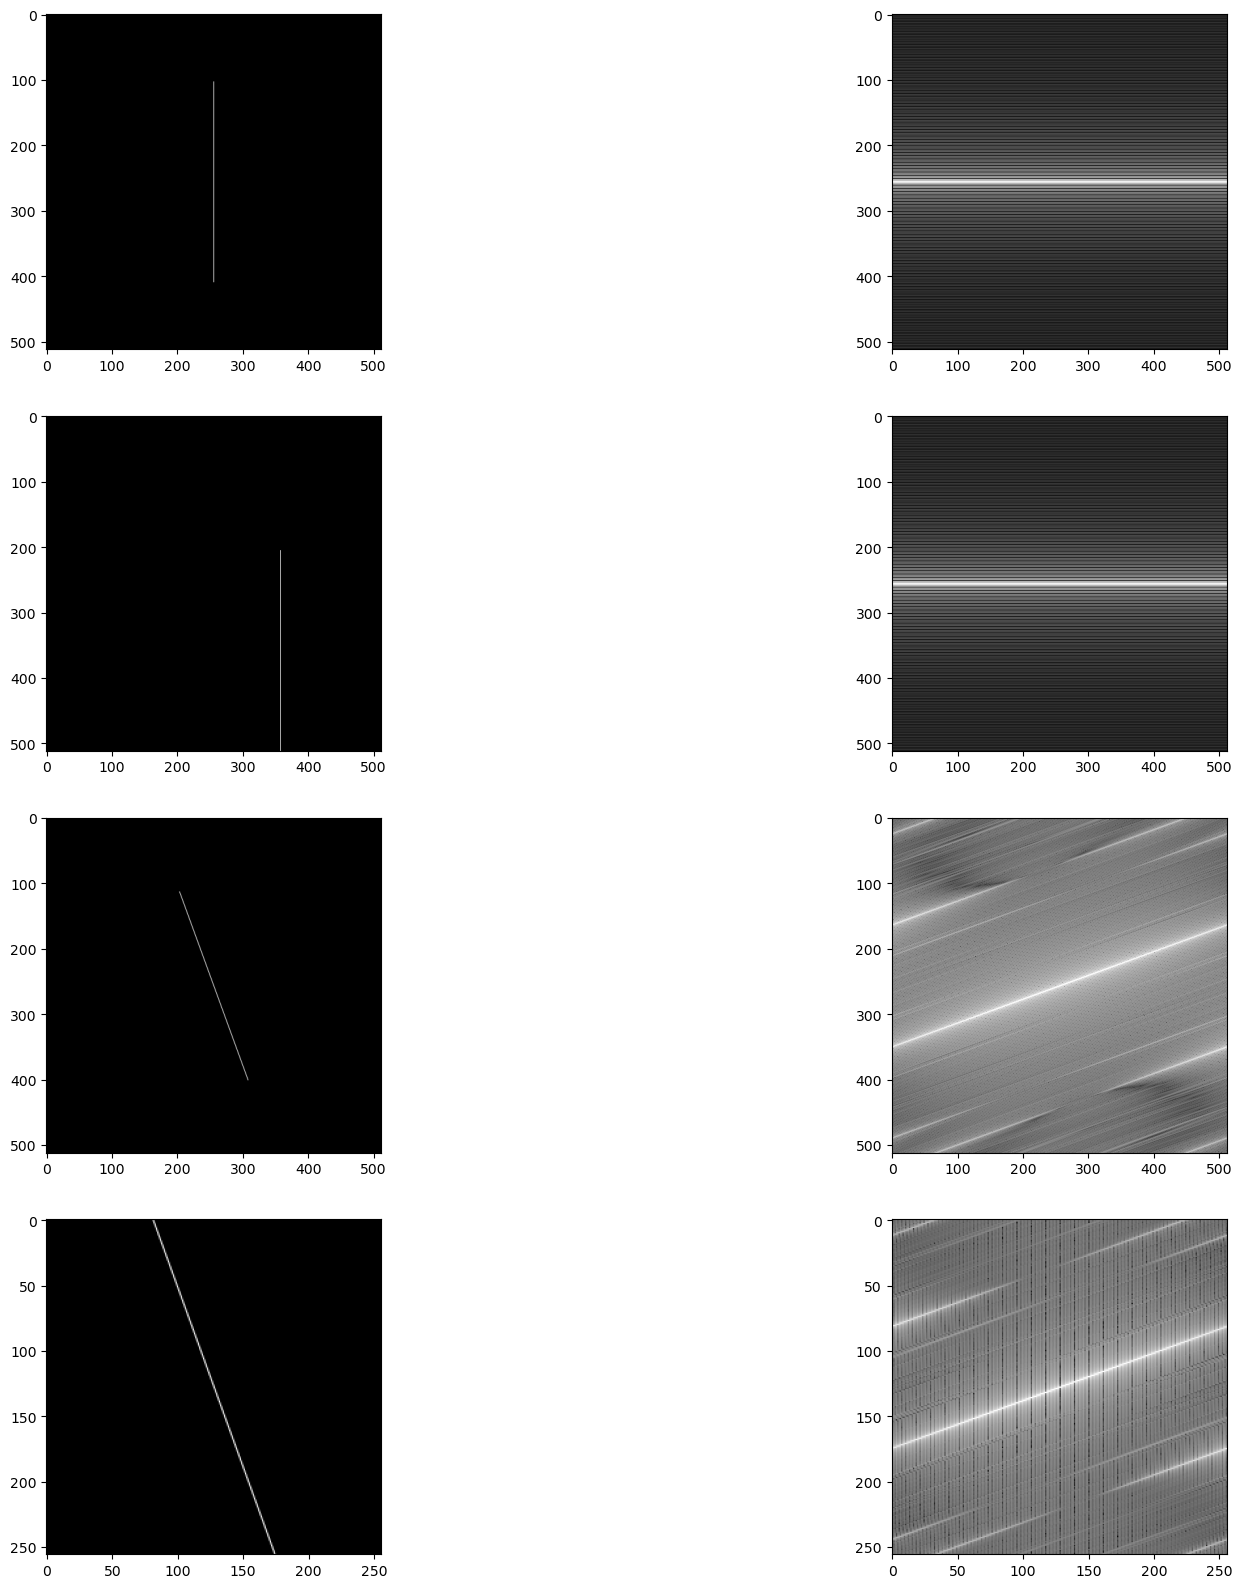

In [30]:

import numpy as np
#import matplotlib
from matplotlib import pyplot as plt
import cv2 as cv

size = 512
im = np.zeros((size,size))
centerIm = int(size/2)

#unit -> pxs
#objWidth = objHeight -> square
#objWidth -> size in pxs along y-ax 
objWidth = int(size*.6)
objHeight = int(size*.6)

#square
#top-left
pt0 = (centerIm-int(objHeight/2),centerIm-int(objWidth/2))
#bottom-rigth
pt1 = (centerIm+int(objHeight/2),centerIm+int(objWidth/2))
white = (255,255,255)
obj0 = cv.rectangle(np.copy(im), pt0, pt1, white,-1)

#rectangle
pt0 = (centerIm-int(objHeight/4),centerIm-int(objWidth/2))
pt1 = (centerIm+int(objHeight/4),centerIm+int(objWidth/2))
obj1 = cv.rectangle(np.copy(im), pt0, pt1, white,-1)

#circle
obj2 = cv.circle(np.copy(im),(centerIm,centerIm), int(objWidth/2),white,-1)

#horizontal line
pt0 = (centerIm-int(objWidth/2),centerIm)
pt1 = (centerIm+int(objWidth/2),centerIm)
obj3 = cv.line(np.copy(im), pt0, pt1, white)

#vertical line
pt0 = (centerIm,centerIm-int(objWidth/2))
pt1 = (centerIm,centerIm+int(objWidth/2))
obj4 = cv.line(np.copy(im), pt0, pt1, white)

dst = np.fft.fft2(obj4)
dst = np.fft.fftshift(dst)
dst = cv.magnitude( np.real(dst), np.imag(dst))
dst = np.log(dst)
#dst = cv.equalizeHist(dst)

#translated obj
M = np.array([[1, 0, int(size*.2)], [0, 1, int(size*.2)]],np.float32)
objTranslated = cv.warpAffine(obj4, M, obj4.shape)

dstTranslated = np.fft.fft2(objTranslated)
dstTranslated = np.fft.fftshift(dstTranslated)
dstTranslated = cv.magnitude( np.real(dstTranslated), np.imag(dstTranslated))
dstTranslated = np.log(dstTranslated)

#rotated obj
M = cv.getRotationMatrix2D((centerIm,centerIm), 20, 1)
objRot = cv.warpAffine(obj4, M, obj4.shape)

dstRot = np.fft.fft2(objRot)
dstRot = np.fft.fftshift(dstRot)
dstRot = cv.magnitude( np.real(dstRot), np.imag(dstRot))
dstRot = np.log(dstRot)

#1.3
sizeROI = size//2
objRotROI = objRot[centerIm-sizeROI//2:centerIm+sizeROI//2,centerIm-sizeROI//2:centerIm+sizeROI//2]

dstRotROI = np.fft.fft2(objRotROI)
dstRotROI = np.fft.fftshift(dstRotROI)
dstRotROI = cv.magnitude( np.real(dstRotROI), np.imag(dstRotROI))
dstRotROI = np.log(dstRotROI)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20,20)) 
ax[0,0].imshow(obj4,cmap="gray")
ax[0,1].imshow(dst,cmap="gray")
ax[1,0].imshow(objTranslated,cmap="gray")
ax[1,1].imshow(dstTranslated,cmap="gray")
ax[2,0].imshow(objRot,cmap="gray")
ax[2,1].imshow(dstRot,cmap="gray")
ax[3,0].imshow(objRotROI,cmap="gray")
ax[3,1].imshow(dstRotROI,cmap="gray")
plt.show()

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

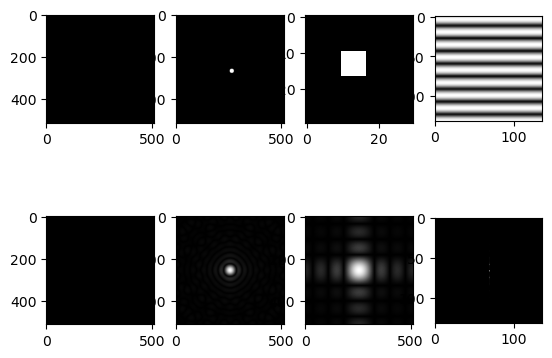

In [175]:
base = np.zeros((512,512))
H,W=base.shape

tuki = cv.imread('imagenes/tuki.png',cv.IMREAD_GRAYSCALE)
tukifft = np.fft.fft2(tuki)
tukifft = np.fft.fftshift(tukifft)
tukifft = cv.magnitude(np.real(tukifft), np.imag(tukifft))

hori=np.copy(base)



horifft = np.fft.fft2(hori)
horifft = np.fft.fftshift(horifft)
horifft = cv.magnitude(np.real(horifft), np.imag(horifft))


circulo = cv.circle(np.copy(base),(264,264), 10,white,-1)
circlefft = np.fft.fft2(circulo)
circlefft = np.fft.fftshift(circlefft)
circlefft = cv.magnitude(np.real(circlefft), np.imag(circlefft))

rectangulo = cv.rectangle(np.copy(base),(200,200),(206,206),white,-1)
rectfft = np.fft.fft2(rectangulo)
rectfft = np.fft.fftshift(rectfft)
rectfft = cv.magnitude(np.real(rectfft), np.imag(rectfft))

fig,ax=plt.subplots(2,4)
ax[0,0].imshow(hori,cmap="gray",vmin=0,vmax=255)
ax[1,0].imshow(horifft,cmap="gray")

ax[0,1].imshow(circulo,cmap="gray")
ax[1,1].imshow(circlefft,cmap="gray")

ax[0,2].imshow(rectangulo[190:220,190:220],cmap="gray")
ax[1,2].imshow(rectfft,cmap="gray")

ax[0,3].imshow(tuki,cmap="gray")
ax[1,3].imshow(tukifft,cmap="gray")

plt.show()

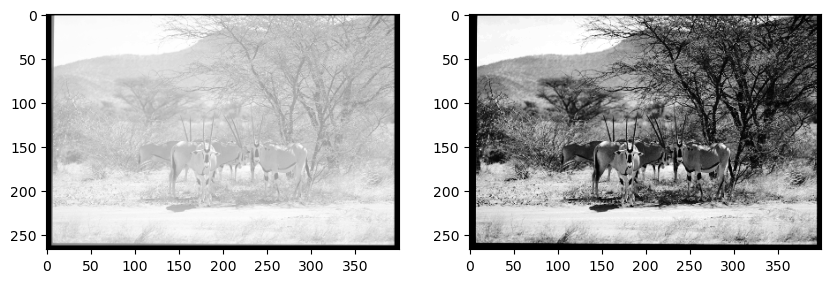

In [195]:
zebra = cv.imread("imagenes/imagenB.tif",cv.IMREAD_GRAYSCALE)
zebra3= zebra - cv.boxFilter()

zebra2=cv.equalizeHist(zebra)


fig,ax=plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(zebra,cmap="gray")
ax[1].imshow(zebra2,cmap="gray")
plt.show()